In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nbimporter
import mainstream_tests

Importing Jupyter notebook from mainstream_tests.ipynb


In [2]:
def get_songs_data(cleaned_data, recommended=True, obs_threshold=7):
    """
    Gets the number of songs and plays for each user (calculates S/P diversity index)
    :param obs_threshold: user must have this number of observations of more to be kept in the dataset
    :param cleaned_data: data after removing outliers
    :param recommended: gets the recommended part of the dataset if True, the organic part otherwise
    :return: a pandas Series with [user_id, S/P] as its rows
    """
    # Separating based on entry's origin -- should use map function if refactoring ever occurs
    if recommended:
        songs_data = cleaned_data[cleaned_data["origin"].str.contains("flow|reco")]
    else:
        songs_data = cleaned_data[~cleaned_data["origin"].str.contains("flow|reco")]

    # Computing for each user every S and their respective P
    songs_data = songs_data.groupby(["user_id", "sng_id"]).size()

    # Determine and drop cases with too few observations (see obs_threshold)
    thresh_tester = songs_data.sum(level="user_id")
    thresh_tester = thresh_tester[thresh_tester < obs_threshold]
    songs_data.drop(thresh_tester.index.values, inplace=True)

    # No exception will be raised even on empty series (in case no value is above obs-threshold)
    songs_data = songs_data.groupby(["user_id"]).size().divide(songs_data.sum(level="user_id"))
    return songs_data

In [3]:
FILE_NAME = "../../data/artist_streams.csv"

MIN_REC = 17
MIN_ORG = 83

print("Reading data...")
data = pd.read_csv(FILE_NAME)
data

Reading data...


,user_id,ts,sng_id,album_id,listening_time,listen_type,origin,art_id
0,53a2a460127df49eef5976193c14728c695c3463,1471344689,121710324,12721422,203,MOD,page_playlist,249599
1,d81f8a1d9fd30af3c189fbe99c26fd6d4db11375,1471364400,121710324,12721422,1,MOD,page_playlist,249599
2,b26ce863e9161cc7e36cdf254927457cc5ceb55b,1471320765,121710324,12721422,203,MOD,page_playlist,249599
3,206929899c1bfc3c49174d20824ab1dc77758567,1471355821,121710324,12721422,115,smartradio,flow,249599
4,111f74340b5ef733f7dc99dc5494de3da4dbeea7,1471336531,121710324,12721422,203,smartradio,flow,249599
...,...,...,...,...,...,...,...,...
2242112,bb2a3a806a8d9ae05bc63fa2182a3fb645530a49,1471505913,117303310,12174146,14,MOD,page_album,1197905
2242113,92ff662b58d3bd81e5cdc06a6438ad4bf490d938,1471983156,9900601,907173,18,MOD,page_album,1182806
2242114,92ff662b58d3bd81e5cdc06a6438ad4bf490d938,1471982447,9900591,907173,9,MOD,page_album,1182806
2242115,92ff662b58d3bd81e5cdc06a6438ad4bf490d938,1471982430,9900589,907173,8,MOD,page_album,1182806


In [4]:
data = mainstream_tests.clean_data(data)
data

Computing z-score...
Cleaning...


,user_id,ts,sng_id,album_id,listening_time,listen_type,origin,art_id
0,53a2a460127df49eef5976193c14728c695c3463,1471344689,121710324,12721422,203,MOD,page_playlist,249599
2,b26ce863e9161cc7e36cdf254927457cc5ceb55b,1471320765,121710324,12721422,203,MOD,page_playlist,249599
3,206929899c1bfc3c49174d20824ab1dc77758567,1471355821,121710324,12721422,115,smartradio,flow,249599
4,111f74340b5ef733f7dc99dc5494de3da4dbeea7,1471336531,121710324,12721422,203,smartradio,flow,249599
5,5f935bea161673f83b0645325bc3da5d113b7f91,1471353443,121710324,12721422,203,MOD,page_playlist,249599
...,...,...,...,...,...,...,...,...
2242099,b3007b94f1a0eb95c508d4fea8320b862ce29a7b,1473194917,93916044,9543328,44,MOD,page_album,308253
2242104,2ad14bc4eb38a15310b0b00b87494a67ed47100d,1475437996,113798794,11786202,73,MOD,page_artist,4312845
2242106,2130c0788bffdf1acc303448c710cee67fc1a629,1476980760,75644372,7492179,84,MOD,page_album,417037
2242110,a351ff8a54dcb58cfa06de787d010220a9565fa2,1471467359,13157903,1207138,44,MOD,page_artist,2380


In [31]:
print("Computing diversity ratio...")
rec_data = get_songs_data(data, recommended=True, obs_threshold=MIN_REC)
org_data = get_songs_data(data, recommended=False, obs_threshold=MIN_ORG)

print("Organizing data...")
# get_songs_data produces a pd.Series, which we turn into a DataFrame before adjusting some column names
org_data = org_data.to_frame()
rec_data = rec_data.to_frame()
org_data.index.names = ["user"]
rec_data.index.names = ["user"]
org_data.columns = ["ratio"]
rec_data.columns = ["ratio"]
org_data["recommended"] = 0
rec_data["recommended"] = 1
org_data = pd.concat([org_data, rec_data])
org_data = org_data.reset_index()

Computing diversity ratio...
Organizing data...


In [32]:
org_data

,user,ratio,recommended
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259752,0
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.279727,0
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272516,0
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.386520,0
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.512795,0
...,...,...,...
1649,fc0d0fd88d4cae1188215a8eb3628212bf19a10c,0.493548,1
1650,fc40a618704ff82958abed2a4b60c8df8763efb2,0.762195,1
1651,fcaf2146b220060147e08cd16997849ed7f02bf9,0.564220,1
1652,fdf2bdc014d1f3c3e69e4d4828d449378805c5d7,0.677835,1


In [33]:
# Remove singletons
org_data = org_data[org_data.groupby("user").user.transform(len) > 1]
org_data

,user,ratio,recommended
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259752,0
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.279727,0
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.386520,0
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.512795,0
5,0312c046fd802a6fe868372727930a03595e029f,0.037857,0
...,...,...,...
1648,fc0c06108d075e83d477d395223695efd1e35d2c,0.629630,1
1650,fc40a618704ff82958abed2a4b60c8df8763efb2,0.762195,1
1651,fcaf2146b220060147e08cd16997849ed7f02bf9,0.564220,1
1652,fdf2bdc014d1f3c3e69e4d4828d449378805c5d7,0.677835,1


In [34]:
# Adding user bins
u_bins = pd.read_csv("../../data/user_bins.csv")
u_bins.columns = ["user", "u_bin_nb"]
org_data = org_data.merge(u_bins, on="user")
org_data

,user,ratio,recommended,u_bin_nb
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259752,0,4
1,00877d231a1d10859eefd4288ecc493fd1ea3589,0.375527,1,4
2,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.279727,0,3
3,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.531111,1,3
4,0282983996af7f6b2a27cfff67fc8982619561d6,0.386520,0,3
...,...,...,...,...
1277,fcaf2146b220060147e08cd16997849ed7f02bf9,0.564220,1,4
1278,fdf2bdc014d1f3c3e69e4d4828d449378805c5d7,0.356589,0,4
1279,fdf2bdc014d1f3c3e69e4d4828d449378805c5d7,0.677835,1,4
1280,fe016f7c946213bd53ca9b683b7314d24d2dbba9,0.351133,0,2


In [45]:
x = org_data[org_data["recommended"] == 0].reset_index().drop("index", axis=1)["ratio"]
y = org_data[org_data["recommended"] == 1].reset_index().drop("index", axis=1)["ratio"]
classes = org_data[org_data["recommended"] == 0].reset_index().drop("index", axis=1)["u_bin_nb"].rename("bin_u")
x

0      0.259752
1      0.279727
2      0.386520
3      0.512795
4      0.037857
         ...   
636    0.250209
637    0.190212
638    0.714602
639    0.356589
640    0.351133
Name: ratio, Length: 641, dtype: float64

In [46]:
classes.groupby(classes).size()

bin_u
1     16
2    169
3    273
4    183
Name: bin_u, dtype: int64

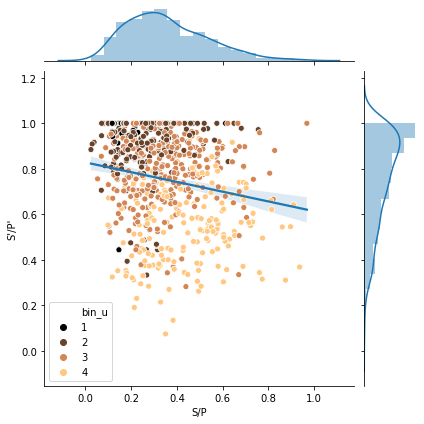

In [51]:
sns.jointplot(x, y, kind='reg', scatter=False)
ax = sns.scatterplot(x, y, hue=classes, palette="copper")
ax.set(xlabel="S/P", ylabel="S'/P'")
plt.savefig("../../results/test.pdf")

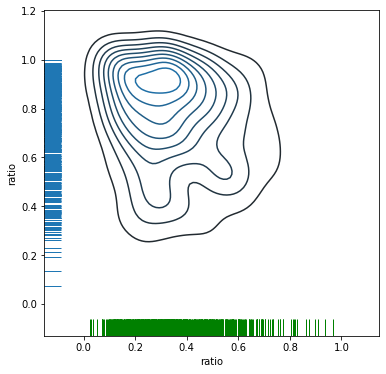

In [78]:
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(x, y, ax=ax)
sns.rugplot(x, color="g", ax=ax)
sns.rugplot(y, vertical=True, ax=ax);